In [1]:
!pip install statsmodels

In [2]:
import platform
import pandas as pd
import numpy as np
v = platform.python_version_tuple();
if float(v[1]) < 10:
    raise Exception("MUST USE Python 3.10 to use MATCH expression!")

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
import sys;
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_colwidth = 1000


In [3]:

#All imports
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression,Ridge, Lasso
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
import statsmodels.api as sm


In [4]:
from enum import Enum, unique

@unique
class PDataType(Enum):
    NUMERICAL = 1
    CATHEGORICAL = 2

def remove_distinct_value_features(df):
    return [e for e in df.columns if df[e].nunique() == 1]

def get_data_type(df, type):
    match type:
        case PDataType.NUMERICAL:
            return df.select_dtypes(np.number);
        case PDataType.CATHEGORICAL:
            return df.select_dtypes(include='object');

#select all cathegorigal data where the first value is more than percent%?
def get_cathegorical_data_by_percent(df, percent):
    col_names = get_data_type(df,PDataType.CATHEGORICAL)
    to_return = []
    for col_name in col_names:
        unique_v_df = (df[col_name].value_counts()).to_frame()
        unique_v_df['percent'] = (unique_v_df/unique_v_df.sum()*100)
        if unique_v_df.iloc[0].percent > percent:
            to_return.append(col_name);
    return to_return
    
def fill_empty_data_with(df, type, filler):
    col_names = get_data_type(df,type)
    for c in col_names:
        test_data_csv[c] = test_data_csv[c].fillna(filler)

In [5]:
DO_NOT_PLOT = False

In [6]:
#define Seaborn color palette to use
import numpy as np
from math import ceil
from itertools import zip_longest
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pie_for_unique_category(df,col_name_x, ax):
    if not DO_NOT_PLOT:
        colors = sns.color_palette('pastel')
        unique_v_df = (df[col_name_x].value_counts()).to_frame()
        unique_v_df['percent'] = (unique_v_df/unique_v_df.sum()*100)
        unique_v_df.plot.pie(y='count', use_index=True,autopct='%0.2f%%', title = f"{col_name_x}", ax = ax)


def plot_hist_for_unique_category(df,col_name_x,col_name_y):
    if not DO_NOT_PLOT:
        unique_v_df = (df[col_name_x].value_counts()).to_frame()
        unique_v_df['percent'] = (unique_v_df/unique_v_df.sum()*100)
        fig, axs = plt.subplots(nrows=len(unique_v_df), figsize=(16,10))
        i = 0;
        for index, row in unique_v_df.iterrows():
            value_percent = row.iloc[1];
            value = row.iloc[0];
            name = index;
            sns.histplot(data=df.loc[df[col_name_x] == name], x=col_name_y, ax = axs[i],bins=100, label =f'{col_name_x} {name} : {value} | {value_percent:.2f}%')
            axs[i].set_xlim(df[col_name_y].min(), df[col_name_y].max())
            axs[i].legend()
            i+=1
        fig.suptitle(f"{col_name_x} on {col_name_y}")
        plt.show()
        
def plot_hist_for_unique_category_stat(df,col_name_x,col_name_y, stat = 'count'):
    if not DO_NOT_PLOT:
        sns.histplot(data=df, x=col_name_x, stat = stat)
        plt.legend()
        plt.show()
                     
    
def plot_unique_category(df,col_name_x,col_name_y):
    if not DO_NOT_PLOT:
        plot_hist_for_unique_category(df,col_name_x,col_name_y)
        fig, axs = plt.subplots(1, 2, figsize=(10,10))
        fig.tight_layout()
        plot_pie_for_unique_category(df,col_name_x,axs[0])
        sns.boxenplot(data=df, x=col_name_x, y=col_name_y, ax = axs[1])
        plt.show()
    
def plot_hist_for_unique_category_array(df,col_names_x,col_name_y):
    if not DO_NOT_PLOT:
        for col_name_x in col_names_x:
            plot_hist_for_unique_category(df,col_name_x,col_name_y)
            plt.show()

#RAVEL returns flatted array, depricated. use to_numpy
def plot_pie_for_unique_category_array(df,col_names_x):
    if not DO_NOT_PLOT:
        n_rows, n_cols = ceil(len(col_names_x) / 3), 3
        fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(20, 80))
        for col_name_x,ax in zip_longest(col_names_x,axs.ravel()):
            if col_name_x is not None:
                colors = sns.color_palette('pastel')
                unique_v_df = (df[col_name_x].value_counts()).to_frame()
                unique_v_df['percent'] = (unique_v_df/unique_v_df.sum()*100)
                unique_v_df.plot.pie(y='count', use_index=True,autopct='%0.2f%%', title = f"{col_name_x}",ax=ax )
            else:
                fig.delaxes(ax)
        plt.draw()
        plt.tight_layout()
    

def plot_correlation_for(df, col_name, n):
    corr = df.corr(numeric_only=True)[col_name].sort_values(ascending=False)
    top_corr = corr[1:n]
    selected_features = list(top_corr.index) + [col_name]
    correlation_matrix = df[selected_features].corr()
    mask = np.triu(correlation_matrix)
    if not DO_NOT_PLOT:
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5, fmt=".2f", vmin=-1, vmax=1,mask=mask)
        plt.title(f"Top of correlation with [{col_name}]", fontsize=16)
        plt.show()
    return top_corr

def plot_overall_correlation_for(df,target_cols,n_count):
    df_no_target = df.copy().drop(columns = target_cols)
    top_correlation = df_no_target.corr().unstack().sort_values(ascending = False).drop_duplicates()[1:n_count]
    top_correlation.plot.bar(grid = True)
    return  top_correlation
def scikit_model_vis(y_valid, y_pred):
    if not DO_NOT_PLOT:
        plt.figure()
        plt.scatter(y_valid, y_pred)
        plt.xlabel('ground truth (y_valid)')
        plt.ylabel('predict (y_pred)')
        plt.show()

    print(f'MAE: {metrics.mean_absolute_error(y_valid, y_pred):.2f}')
    print(f'MSE: {metrics.mean_squared_error(y_valid, y_pred):.2f}')
    print(f'R2: {metrics.r2_score(y_valid, y_pred):.2f}')

# HOMEWORK

The project (homework) task for you will be to gather all the above and prepare a regression model with various features related to a real dataset.


**Multivariate regression case**

In fact, we can treat polynomial regression as the case of the multivariate regression, where the first variable is $x$, the second variable is $x^2$, the third variable is $x^3$. Our regression model is simply:
$$\hat{y} = f(x,x^2,x^3)$$

In your homework you are asked to work with the real multivariate regression case, where analogously:
$$\hat{y} = f(x_1,x_2,x_3,\dots,x_{13})$$

The arguments $x_1,x_2,x_3,\dots,x_{13}$ we use to infer are known as *features*. Their selection and processing (feature engineering) with be subject of other lecture(s) and laboratory classe(s)

You can use any dataset you select. For instance, Scikit-learn offers some exemplary datasets. Before, you worked with the historical dataset related to house prices. Here, you can play with the diabetes data (although if you want, you can use some other dataset interesting for you).

Process the selected dataset, using the following concept:

*   Review the data carefully, pre-process as much as possible. The `diabetes` dataset can be quite nice, but at least some of the features can be correlated.
*   `train_test_split`: treat the case as the supervised learning example, i.e., train with a data subset and then check its quality (score) with another subset of your data.
*   `Pipeline`: use a pipeline, where you first transform the data.
*   Consider simple multivariate regression, but also play with squares, values obtained as mutliplication of two variables, etc.

[If you want to, you can also consider the following, but we have not managed to do that this time:
*   `Lasso`/`Ridge`: second, use linear (or polynomial) regression with regularization (choose L1- or L2-regularization).
*   `GridSearchCV`: use gridsearch to select the $\lambda$ parameter for regularization.
*   `KFold`: Select the $\lambda$ hyperparameter with $k$-fold cross-validation.]

We will see who is able to obtain the best fit without overfitting!

**This homework is obligatory. Please send colab link to piotr.cholda@agh.edu.pl before 22.03.2023.**

In [7]:
from sklearn.datasets import load_diabetes

In [8]:
diabetes = load_diabetes(as_frame=True,scaled=False)

In [9]:
diabetes_df = diabetes.frame.copy()

In [10]:
diabetes_df.columns.to_series()[np.isinf(diabetes_df).any()]
print(diabetes_df.min())


age       19.0000
sex        1.0000
bmi       18.0000
bp        62.0000
s1        97.0000
s2        41.6000
s3        22.0000
s4         2.0000
s5         3.2581
s6        58.0000
target    25.0000
dtype: float64


In [11]:
print(diabetes_df.info())
print(diabetes_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
None
              age         sex         bmi          bp          s1          s2  \
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000   
mean    48.518100    1.468326   26.375792   94.647014  189.140271  115.439140   
std     13.109028    0.499561    4.418122   13.831283   34.608052   30.413081   
min     19.000000    1.000000   18.000000  

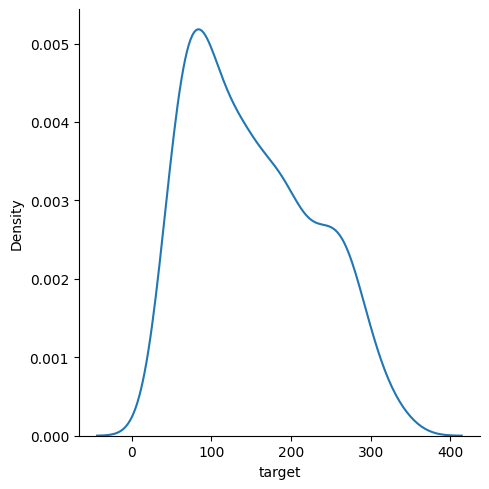

In [12]:
sns.displot(diabetes_df, x = 'target', kind="kde");

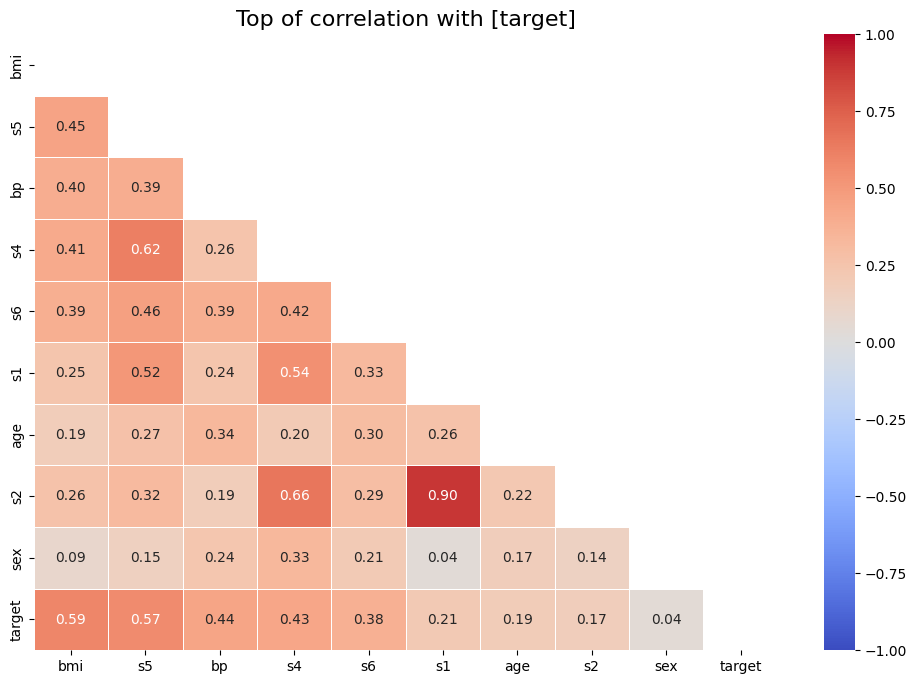

bmi    0.586450
s5     0.565883
bp     0.441482
s4     0.430453
s6     0.382483
s1     0.212022
age    0.187889
s2     0.174054
sex    0.043062
Name: target, dtype: float64

In [13]:
plot_correlation_for(diabetes_df, 'target',10)

s2  s1    0.896663
s4  s2    0.659817
s5  s4    0.617859
s1  s4    0.542207
dtype: float64

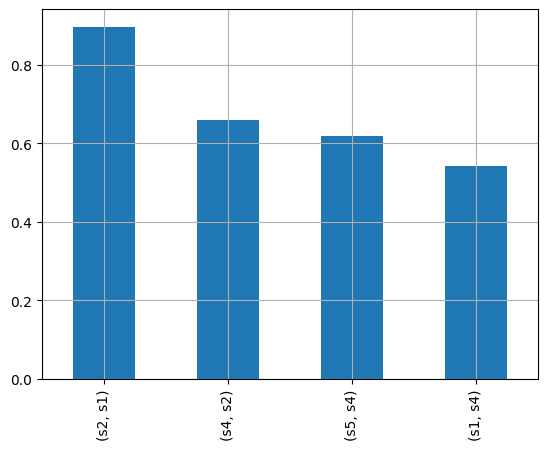

In [14]:
plot_overall_correlation_for(diabetes_df, 'target', 5)

In [15]:
def simple_correlation_with_pipeline(df, target_col, pipeline, test_size=0.3,):
    X = df.copy().drop(columns = target_col)
    y = df.copy()[target_col]
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size)
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    scikit_model_vis(y_test, y_pred)
    print(f"Score : {pipeline.score(X_test,y_test)}")
def simple_correlation_with_statsmodels(_df,_target_col):
    target_col = 'target'
    X = _df.copy().drop(columns = _target_col)
    y = _df.copy()[_target_col]
    X_1 = sm.add_constant(X) # add constant 1 in all the rows
    regression1 = sm.OLS(y,X_1).fit()
    print(regression1.params,"\n")
    print(regression1.summary(),"\n")

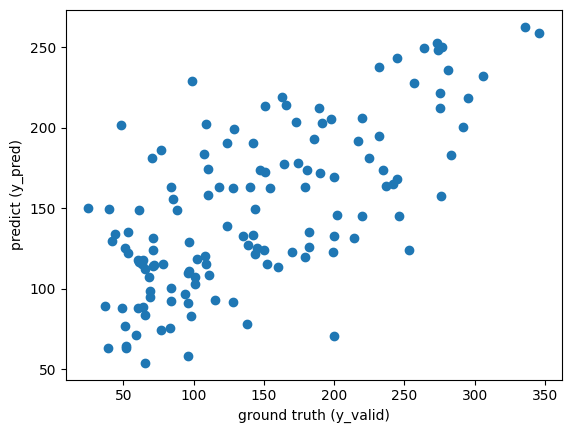

MAE: 45.21
MSE: 3190.25
R2: 0.46
Score : 0.46361571986679595


In [16]:
pipe_lr=Pipeline([
             ('scaler',StandardScaler()),
             ('lr',LinearRegression())])
simple_correlation_with_pipeline(diabetes_df,'target', pipe_lr,  test_size=0.3)

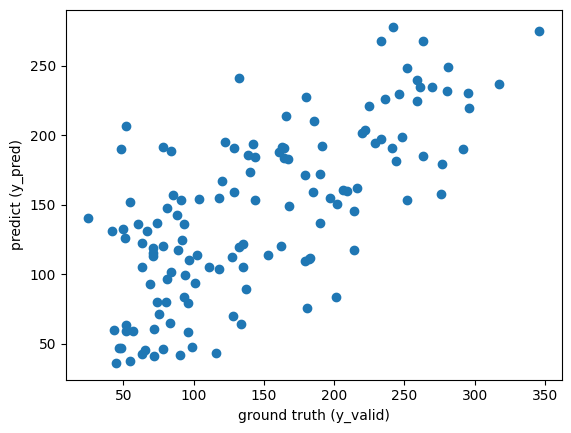

MAE: 44.01
MSE: 2993.71
R2: 0.49
Score : 0.48821227336435724


In [17]:
pipe_min_max=Pipeline([
             ('scaler',MinMaxScaler()),
             ('lr',LinearRegression())])
simple_correlation_with_pipeline(diabetes_df,'target', pipe_min_max,  test_size=0.3)

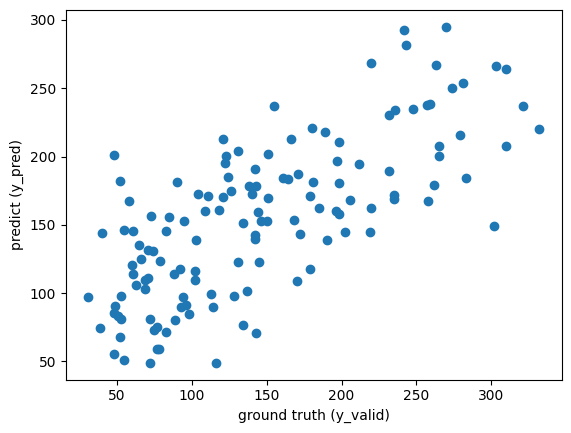

MAE: 43.11
MSE: 2863.69
R2: 0.51
Score : 0.5099299241126003


In [18]:
pipe_max_abs=Pipeline([
             ('scaler',MaxAbsScaler()),
             ('lr',LinearRegression())])
simple_correlation_with_pipeline(diabetes_df,'target', pipe_max_abs,  test_size=0.3)

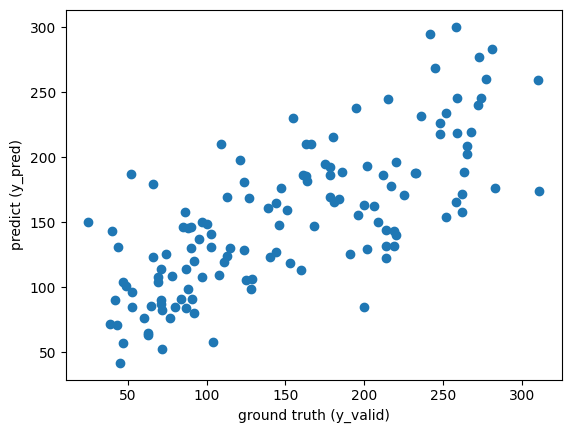

MAE: 40.44
MSE: 2611.12
R2: 0.55
Score : 0.5456103163409325


In [19]:
diabetes_df_s1_s2_mul = diabetes_df.copy()
diabetes_df_s1_s2_mul['s1_s2'] = diabetes_df_s1_s2_mul['s1']*diabetes_df_s1_s2_mul['s1'];
diabetes_df_s1_s2_mul.drop(columns = ['s1', 's2'], inplace=True)
simple_correlation_with_pipeline(diabetes_df_s1_s2_mul,'target', pipe_min_max,  test_size=0.3)


In [20]:
#Those are very unstable.. from 0.38 to 0.56

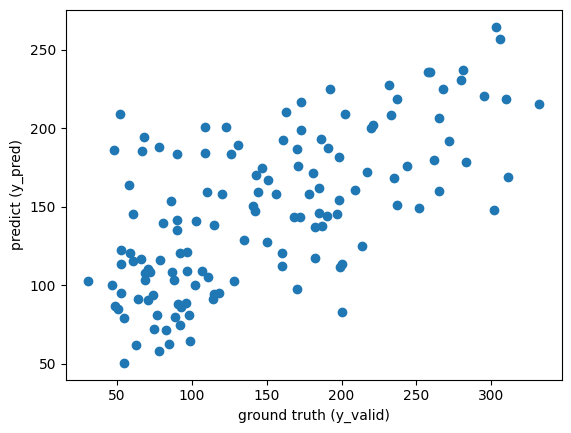

MAE: 44.89
MSE: 3262.25
R2: 0.43
Score : 0.4307740372567743


In [21]:
diabetes_df_s1_s2_sum = diabetes_df.copy()
diabetes_df_s1_s2_sum['s1_s2'] = diabetes_df_s1_s2_sum['s1']+diabetes_df_s1_s2_sum['s1'];
diabetes_df_s1_s2_sum.drop(columns = ['s1', 's2'], inplace=True)
simple_correlation_with_pipeline(diabetes_df_s1_s2_sum,'target', pipe_min_max,  test_size=0.3)

In [22]:
simple_correlation_with_statsmodels(diabetes_df, 'target')

const   -334.567139
age       -0.036361
sex      -22.859648
bmi        5.602962
bp         1.116808
s1        -1.089996
s2         0.746450
s3         0.372005
s4         6.533832
s5        68.483125
s6         0.280117
dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           3.83e-62
Time:                        13:22:08   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust               

In [23]:
simple_correlation_with_statsmodels(diabetes_df_s1_s2_sum, 'target')

const   -261.383227
age       -0.023639
sex      -22.512532
bmi        5.697554
bp         1.109425
s3        -0.461533
s4         5.392979
s5        48.868825
s6         0.286270
s1_s2     -0.157235
dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     51.08
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           1.37e-62
Time:                        13:22:08   Log-Likelihood:                -2387.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     432   BIC:                             4835.
Df Model:                           9                                         
Covariance Type:            nonrobust                                   

In [24]:
simple_correlation_with_statsmodels(diabetes_df_s1_s2_sum, 'target')

const   -261.383227
age       -0.023639
sex      -22.512532
bmi        5.697554
bp         1.109425
s3        -0.461533
s4         5.392979
s5        48.868825
s6         0.286270
s1_s2     -0.157235
dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     51.08
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           1.37e-62
Time:                        13:22:08   Log-Likelihood:                -2387.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     432   BIC:                             4835.
Df Model:                           9                                         
Covariance Type:            nonrobust                                   

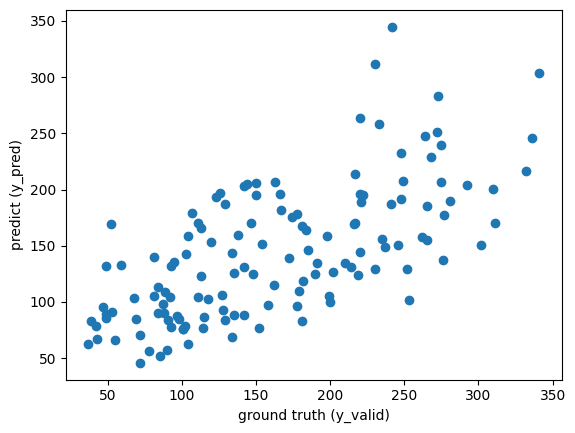

MAE: 49.46
MSE: 3647.23
R2: 0.38
Score : 0.3797392454908435
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s3      442 non-null    float64
 5   s6      442 non-null    float64
 6   target  442 non-null    float64
 7   s2_s1   442 non-null    float64
 8   s4_s2   442 non-null    float64
 9   s5_s4   442 non-null    float64
 10  s1_s4   442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [25]:
diabetes_df_mul_coor = diabetes_df.copy()
diabetes_df_mul_coor['s2_s1'] = diabetes_df_mul_coor['s2']*diabetes_df_mul_coor['s1'];
diabetes_df_mul_coor['s4_s2'] = diabetes_df_mul_coor['s4']*diabetes_df_mul_coor['s2'];
diabetes_df_mul_coor['s5_s4'] = diabetes_df_mul_coor['s5']*diabetes_df_mul_coor['s4'];
diabetes_df_mul_coor['s1_s4'] = diabetes_df_mul_coor['s1']*diabetes_df_mul_coor['s4'];

diabetes_df_mul_coor.drop(columns = ['s1', 's2','s4','s5'], inplace=True)
simple_correlation_with_pipeline(diabetes_df_mul_coor,'target', pipe_min_max,  test_size=0.3)
diabetes_df_mul_coor.info()

s4_s2  s1_s4    0.974409
s5_s4  s1_s4    0.928003
s4_s2  s5_s4    0.860979
s2_s1  s4_s2    0.860603
dtype: float64


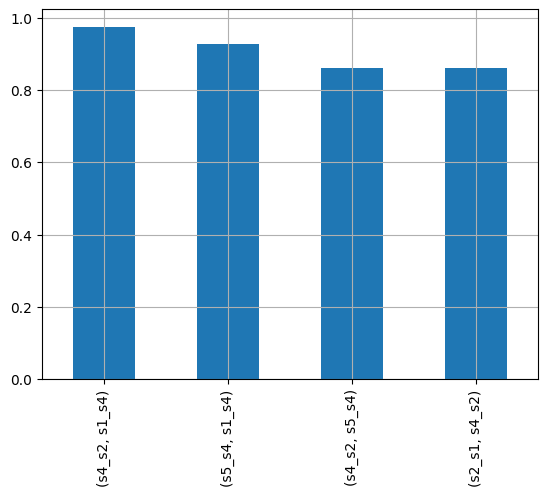

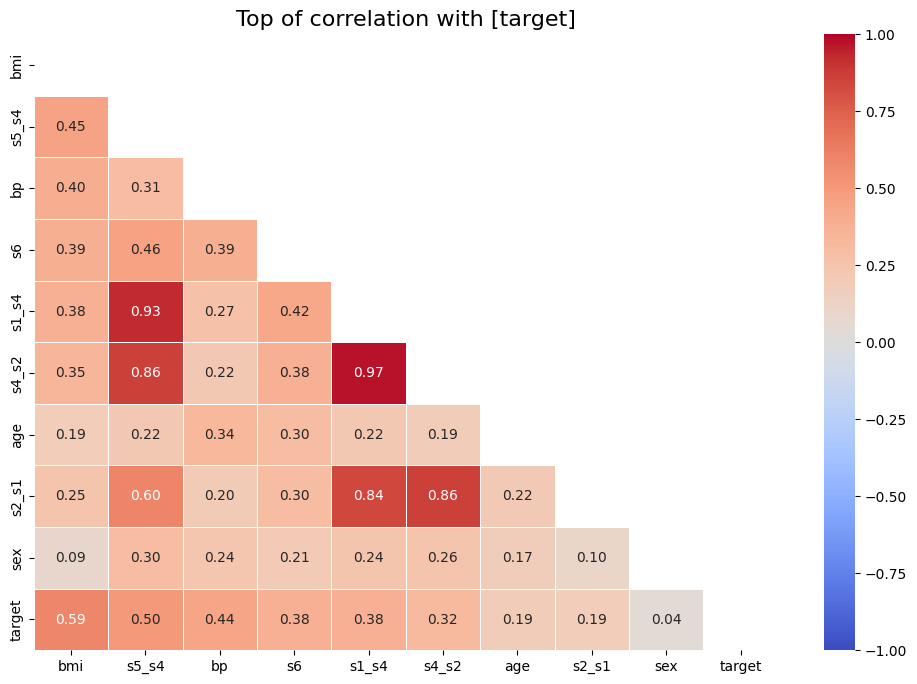

bmi      0.586450
s5_s4    0.495941
bp       0.441482
s6       0.382483
s1_s4    0.379702
s4_s2    0.317102
age      0.187889
s2_s1    0.185370
sex      0.043062
Name: target, dtype: float64

In [26]:
print(plot_overall_correlation_for(diabetes_df_mul_coor, 'target', 5))
plot_correlation_for(diabetes_df_mul_coor, 'target',10)

s4_s2  s1_s4    0.974409
s5_s4  s1_s4    0.928003
s4_s2  s5_s4    0.860979
s2_s1  s4_s2    0.860603
dtype: float64


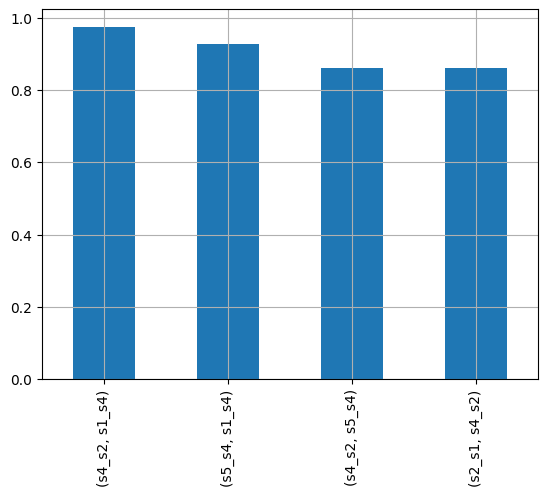

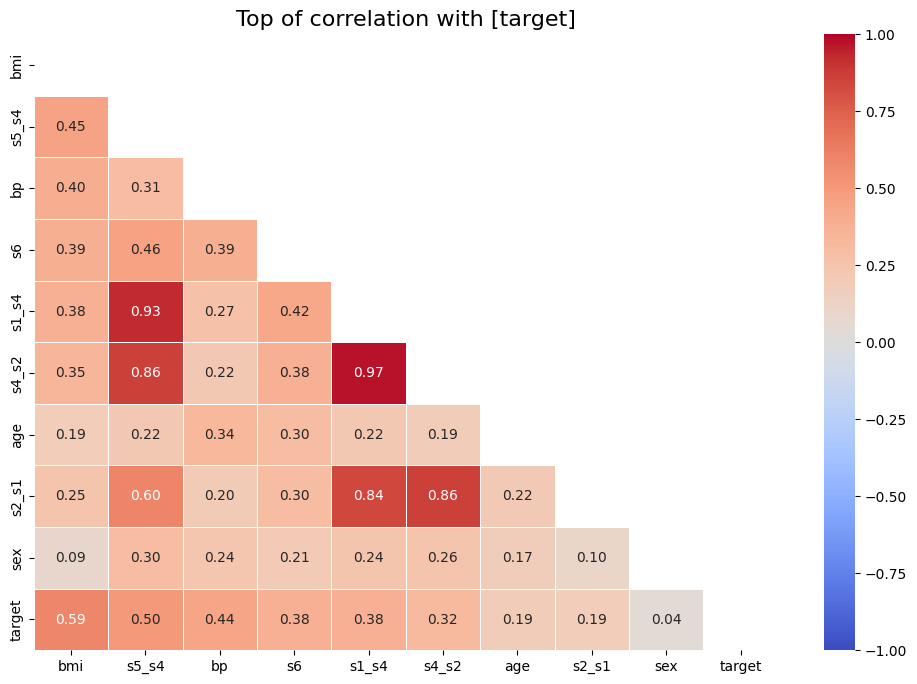

bmi      0.586450
s5_s4    0.495941
bp       0.441482
s6       0.382483
s1_s4    0.379702
s4_s2    0.317102
age      0.187889
s2_s1    0.185370
sex      0.043062
Name: target, dtype: float64

In [27]:
print(plot_overall_correlation_for(diabetes_df_mul_coor, 'target', 5))
plot_correlation_for(diabetes_df_mul_coor, 'target',10)

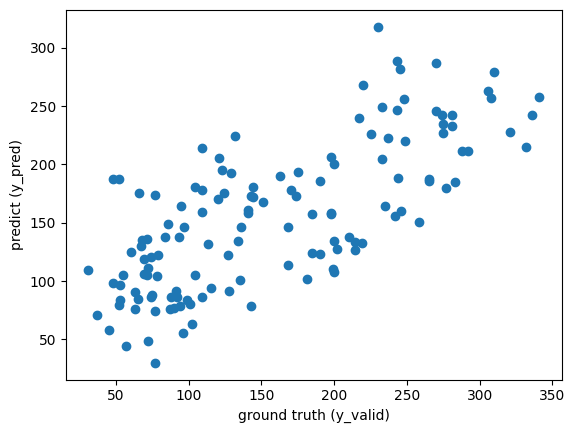

MAE: 46.35
MSE: 3150.67
R2: 0.54
Score : 0.5362863199017993
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s3      442 non-null    float64
 5   s6      442 non-null    float64
 6   target  442 non-null    float64
 7   s2_s1   442 non-null    float64
 8   s4_s2   442 non-null    float64
 9   s5_s4   442 non-null    float64
 10  s1_s4   442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [28]:
diabetes_df_mul_coor_2 = diabetes_df.copy()
diabetes_df_mul_coor_2['s2_s1_s4'] = diabetes_df_mul_coor_2['s2']*diabetes_df_mul_coor_2['s1']*diabetes_df_mul_coor_2['s4'];
diabetes_df_mul_coor_2['s5_s4_s2'] = diabetes_df_mul_coor_2['s5']*diabetes_df_mul_coor_2['s4']*diabetes_df_mul_coor_2['s2'];
diabetes_df_mul_coor_2['s5_s4_s1'] = diabetes_df_mul_coor_2['s5']*diabetes_df_mul_coor_2['s4']*diabetes_df_mul_coor_2['s1'];

diabetes_df_mul_coor_2.drop(columns = ['s1', 's2','s4','s5'], inplace=True)
simple_correlation_with_pipeline(diabetes_df_mul_coor_2,'target', pipe_min_max,  test_size=0.3)
diabetes_df_mul_coor.info()

s2_s1_s4  s5_s4_s2    0.971745
s5_s4_s2  s5_s4_s1    0.971277
s5_s4_s1  s2_s1_s4    0.917020
          s6          0.448065
dtype: float64


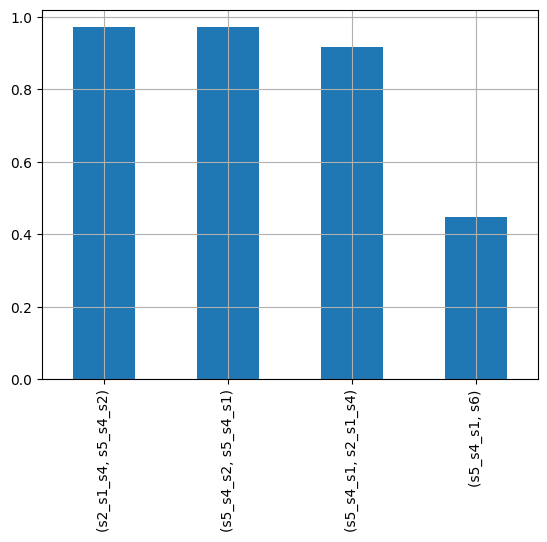

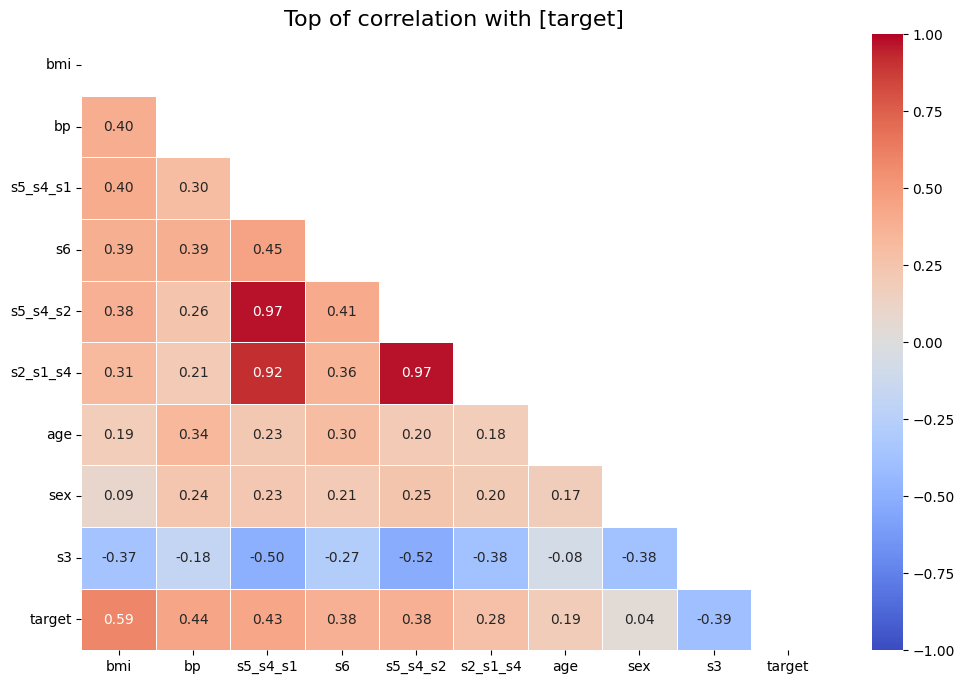

bmi         0.586450
bp          0.441482
s5_s4_s1    0.431267
s6          0.382483
s5_s4_s2    0.377423
s2_s1_s4    0.279046
age         0.187889
sex         0.043062
s3         -0.394789
Name: target, dtype: float64

In [29]:
print(plot_overall_correlation_for(diabetes_df_mul_coor_2, 'target', 5))
plot_correlation_for(diabetes_df_mul_coor_2, 'target',10)

# How can I combine those feature in realy good way?

# Ridge!

Ridge with solver = auto


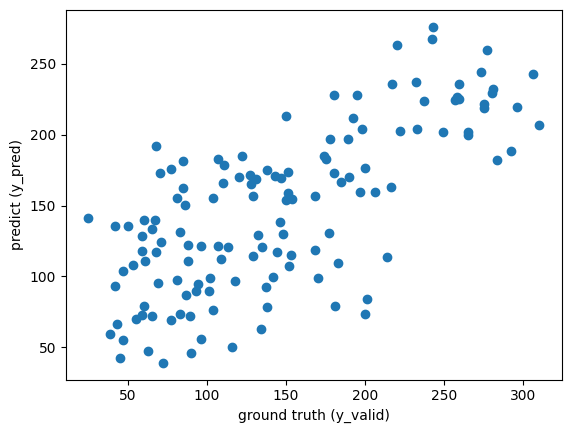

MAE: 41.62
MSE: 2662.20
R2: 0.51
Score : 0.5065968152258313
Ridge with solver = sag


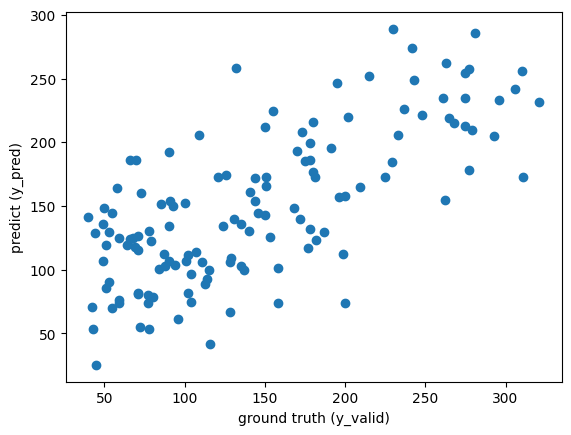

MAE: 42.41
MSE: 2837.60
R2: 0.51
Score : 0.5100424539083145
Ridge with solver = sparse_cg


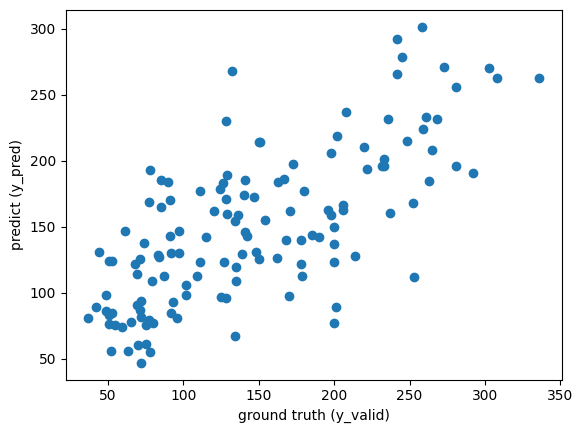

MAE: 41.07
MSE: 2614.78
R2: 0.50
Score : 0.5029459079904073
Ridge with solver = saga


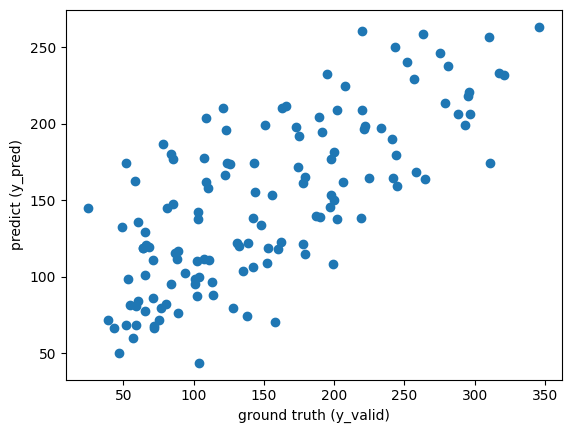

MAE: 42.55
MSE: 2803.15
R2: 0.53
Score : 0.5341048550114038
Ridge with solver = lsqr


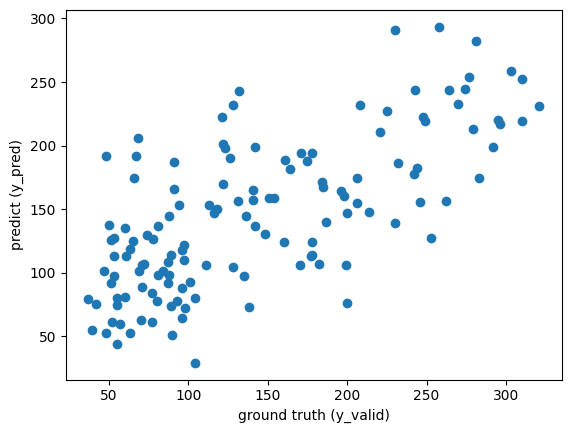

MAE: 44.94
MSE: 3129.36
R2: 0.49
Score : 0.4864608658911782
Ridge with solver = svd


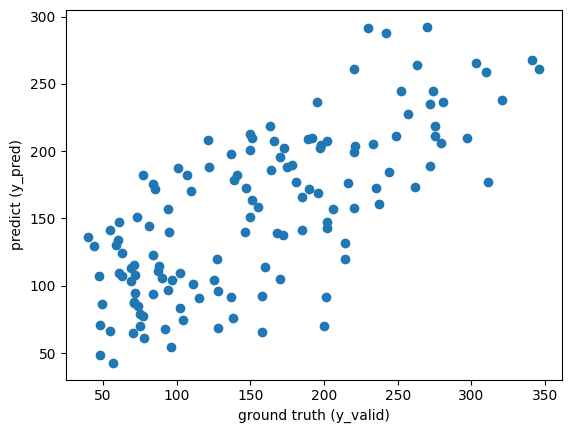

MAE: 43.59
MSE: 2790.96
R2: 0.53
Score : 0.5326675726529606
Ridge with solver = cholesky


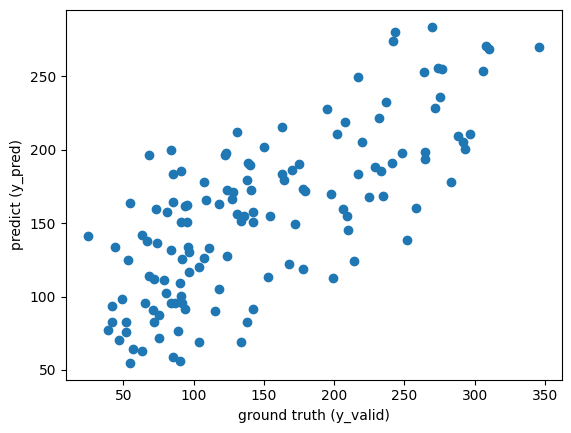

MAE: 43.72
MSE: 2794.70
R2: 0.54
Score : 0.5396021892492067


In [30]:
solvers = {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'};
for s in solvers:
    pipe_standard_ridge =Pipeline([
                 ('scaler',StandardScaler()),
                 ('ridge',Ridge(solver=s))])
    print(f"Ridge with solver = {s}")
    simple_correlation_with_pipeline(diabetes_df,'target', pipe_standard_ridge,  test_size=0.3)


# LASSO!

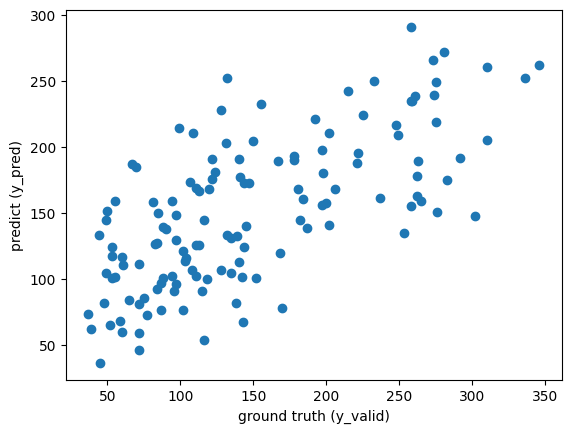

MAE: 45.05
MSE: 3219.76
R2: 0.47
Score : 0.4696499955915412


In [31]:
pipe_standard_ridge =Pipeline([
             ('scaler',StandardScaler()),
             ('ridge',Lasso())])
simple_correlation_with_pipeline(diabetes_df,'target', pipe_standard_ridge,  test_size=0.3)